<a href="https://colab.research.google.com/github/anazaharijeva/standard_project_vnp/blob/master/StandardProject_203021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ана Захаријева 203021

# Тема 32:
Risk Factor Identification: Identify the risk factors associated with long COVID from #LongCovid tweets. Collect annotations indicating whether each tweet mentions a particular risk factor (e.g., age, pre-existing conditions, vaccination status). This can help understand the demographic and health-related factors linked to Long COVID.

Собирање на подаротиците од: https://www.kaggle.com/

Линк од datasetot: https://www.kaggle.com/datasets/matt0922/longcovid-tweets

In [ ]:
#install libraries
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, hamming_loss

In [ ]:
# Load your dataset
data = pd.read_csv('/content/lc2022.csv', error_bad_lines=False)

<ipython-input-58-40b4f99ce6a3>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('/content/lc2022.csv', error_bad_lines=False)


In [ ]:
data

,Date,User,Tweets
0,2022-01-31 23:59:18+00:00,RobocapFriend,@kathymi71147962 @RiaRex2 My s-in-law had Covi...
1,2022-01-31 23:59:18+00:00,LupusWarrior69,@MarinaSilver6 Long COVID sucks. But you make ...
2,2022-01-31 23:58:12+00:00,ElsaOrgana,@PortiaMcGonagal It’s been one for about a mon...
3,2022-01-31 23:57:59+00:00,WilliamAHirsch,Living with covid also means lifelong health p...
4,2022-01-31 23:57:58+00:00,persistingvirus,Long Covid. Scientists agreed leading theory i...
...,...,...,...
143049,2022-01-04 02:12:40+00:00,maryampatel,@ravenscimaven PEM is probably the worst thing...
143050,2022-01-04 02:12:14+00:00,hereandnow155,@Malcolm68761322 @ChristieCooper7 @7NewsMelbou...
143051,2022-01-04 02:11:58+00:00,JerzyTigger79,@Gerry_Martini People forget that mild just me...
143052,2022-01-04 02:11:58+00:00,WeiDuCNA,@jeremyyellen @mercuriobryan The right questio...


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Cleaning data
data.loc[5, 'Tweets'] = float('nan')
# Preprocess tweet text
def preprocess_text(text):

    if isinstance(text, float) and pd.isna(text):
        return ''
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Remove hashtags and mentions
    text = re.sub(r'#\w+|@\w+', '', text)
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Tokenize text and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

data['cleaned_tweets'] = data['Tweets'].apply(preprocess_text)

In [ ]:
data

,Date,User,Tweets,cleaned_tweets
0,2022-01-31 23:59:18+00:00,RobocapFriend,@kathymi71147962 @RiaRex2 My s-in-law had Covi...,sinlaw covid months ago still long covid debil...
1,2022-01-31 23:59:18+00:00,LupusWarrior69,@MarinaSilver6 Long COVID sucks. But you make ...,long covid sucks make look sexy
2,2022-01-31 23:58:12+00:00,ElsaOrgana,@PortiaMcGonagal It’s been one for about a mon...,one month long covid solidarity one fed lady a...
3,2022-01-31 23:57:59+00:00,WilliamAHirsch,Living with covid also means lifelong health p...,living covid also means lifelong health proble...
4,2022-01-31 23:57:58+00:00,persistingvirus,Long Covid. Scientists agreed leading theory i...,long covid scientists agreed leading theory sy...
...,...,...,...,...
143049,2022-01-04 02:12:40+00:00,maryampatel,@ravenscimaven PEM is probably the worst thing...,pem probably worst thing long covid experience...
143050,2022-01-04 02:12:14+00:00,hereandnow155,@Malcolm68761322 @ChristieCooper7 @7NewsMelbou...,sorry know anyone delta still major issues kno...
143051,2022-01-04 02:11:58+00:00,JerzyTigger79,@Gerry_Martini People forget that mild just me...,people forget mild means didnt need hospitaliz...
143052,2022-01-04 02:11:58+00:00,WeiDuCNA,@jeremyyellen @mercuriobryan The right questio...,right question ask medical expert reasons beli...


In [ ]:
risk_factors = ["age", "pre-existing conditions", "vaccination status"]

def annotate_risk_factors(text):
    annotations = {}
    for factor in risk_factors:
        if factor in text:
            annotations[factor] = True
        else:
            annotations[factor] = False
    return annotations

# Apply annotation function to each cleaned tweet and store in a new column 'Risk_Factor_Annotations'
data['Risk_Factor_Annotations'] = data['cleaned_tweets'].apply(annotate_risk_factors)

In [ ]:
factor_counts = {factor: data['Risk_Factor_Annotations'].apply(lambda x: x[factor]).sum() for factor in risk_factors}


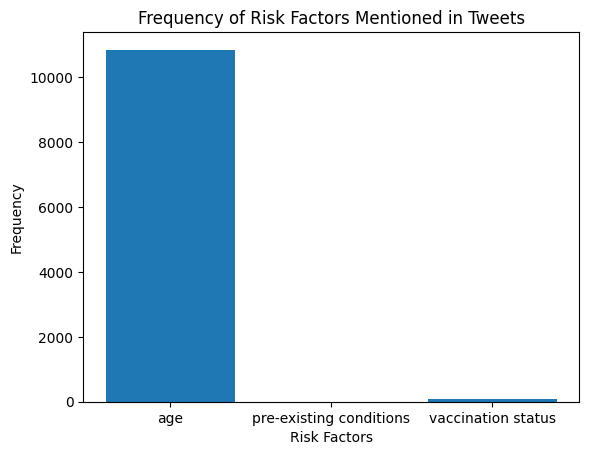

In [ ]:
plt.bar(factor_counts.keys(), factor_counts.values())
plt.xlabel("Risk Factors")
plt.ylabel("Frequency")
plt.title("Frequency of Risk Factors Mentioned in Tweets")
plt.show()


In [ ]:
# Interpretation of results
for factor, count in factor_counts.items():
    print(f"{factor}: {count} mentions")

# Calculate the percentage of tweets mentioning each risk factor
total_tweets = len(df)
for factor, count in factor_counts.items():
    percentage = (count / total_tweets) * 100
    print(f"{factor}: {percentage:.2f}% of tweets mention this risk factor")

age: 10854 mentions
pre-existing conditions: 0 mentions
vaccination status: 85 mentions
age: 7.59% of tweets mention this risk factor
pre-existing conditions: 0.00% of tweets mention this risk factor
vaccination status: 0.06% of tweets mention this risk factor


In [ ]:
pip install textblob


In [ ]:
#Sentiment Analysis
from textblob import TextBlob

# Function to calculate sentiment polarity of a text
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

# Calculate sentiment polarity for tweets mentioning each risk factor
for factor in risk_factors:
    factor_tweets = data[data['Risk_Factor_Annotations'].apply(lambda x: x[factor])]
    factor_tweets['Sentiment_Polarity'] = factor_tweets['Tweets'].apply(get_sentiment)

    # Calculate average sentiment polarity
    avg_sentiment = factor_tweets['Sentiment_Polarity'].mean()
    print(f"{factor} Sentiment Polarity: {avg_sentiment:.2f}")


<ipython-input-68-3e1bb76f044f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_tweets['Sentiment_Polarity'] = factor_tweets['Tweets'].apply(get_sentiment)


age Sentiment Polarity: 0.03
pre-existing conditions Sentiment Polarity: nan
vaccination status Sentiment Polarity: 0.03


<ipython-input-68-3e1bb76f044f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_tweets['Sentiment_Polarity'] = factor_tweets['Tweets'].apply(get_sentiment)


In [ ]:
# Function to perform Named Entity Recognition (NER)
def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ == 'PERSON']  # Adjust 'PERSON' label as needed
    return entities

# Extract mentions of risk factors using NER
for factor in risk_factors:
    factor_tweets = data[data['Risk_Factor_Annotations'].apply(lambda x: x[factor])]
    factor_tweets['Mentions'] = factor_tweets['Tweets'].apply(extract_entities)
    print(f"{factor} Mentions:")
    print(factor_tweets['Mentions'].head())


<ipython-input-34-decf5e4776f9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_tweets['Mentions'] = factor_tweets['Tweets'].apply(extract_entities)


age Mentions:
17    []
34    []
35    []
44    []
51    []
Name: Mentions, dtype: object
pre-existing conditions Mentions:
Series([], Name: Mentions, dtype: object)
vaccination status Mentions:
4749            [https://t.co/kJGEMlraaM]
8470     [@KnightRustyArm @DavidSteadson]
9009                                   []
11446                                  []
17947                                  []
Name: Mentions, dtype: object


<ipython-input-34-decf5e4776f9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factor_tweets['Mentions'] = factor_tweets['Tweets'].apply(extract_entities)


In [ ]:
# Prepare the data
X = data['cleaned_tweets']
y = data['Risk_Factor_Annotations']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Vectorize the text data using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [ ]:

# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()


In [ ]:

# Transform the target labels into a binary multi-label format
y_train_encoded = mlb.fit_transform(y_train)
y_test_encoded = mlb.transform(y_test)

# Train a MultiOutputClassifier (Random Forest) for multi-label classification
classifier = MultiOutputClassifier(RandomForestClassifier(random_state=42))
classifier.fit(X_train_tfidf, y_train_encoded)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=42))

In [ ]:
# Predict risk factor annotations on the test set
y_pred_encoded = classifier.predict(X_test_tfidf)

# Inverse transform the predictions to the original format
y_pred = mlb.inverse_transform(y_pred_encoded)



In [ ]:
# Evaluate the model using F1-score and Hamming loss
f1_micro = f1_score(y_test_encoded, y_pred_encoded, average='micro')
hamming = hamming_loss(y_test_encoded, y_pred_encoded)

print(f"F1 Micro Score: {f1_micro:.2f}")
print(f"Hamming Loss: {hamming:.2f}")

F1 Micro Score: 1.00
Hamming Loss: 0.00
